Find the color consistency between two superpixels. This consistency value will then be used to weigh the Edge Adjacency Matrix.

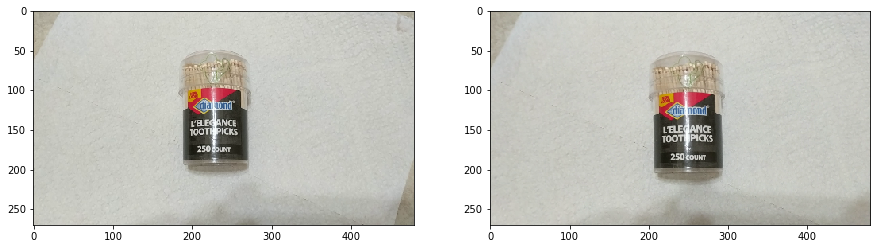

In [76]:
import sys
sys.path.append("../")
import superpixels as sp
from helpers import *
import imageio
from matplotlib import pyplot as plt
import numpy as np
import cv2

sp.num_superpixels = 1000
filename = '../data/toothpick.mp4'
vid = imageio.get_reader(filename, 'ffmpeg')

img1 = get_smaller_image(vid, 0)
img2 = get_smaller_image(vid, 20)

sp_map1 = sp.extract_superpixels(img1)
sp_map2 = sp.extract_superpixels(img2)

plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(img1)
plt.subplot(222), plt.imshow(img2)
plt.show()

# img1 = cv2.cvtColor(img1, cv2.COLOR_RGB2HSV)
# img2 = cv2.cvtColor(img2, cv2.COLOR_RGB2HSV)

327
[ 0.67843139  0.65882355  0.60392159]
[[ 0.66830254  0.6487355   0.5903679 ]
 [ 0.67083611  0.65567857  0.60141538]
 [ 0.68260319  0.66317026  0.60625022]
 [ 0.69170939  0.67282818  0.61011275]
 [ 0.69515387  0.67691708  0.61745423]
 [ 0.69568719  0.6797707   0.61834114]
 [ 0.69691969  0.68107109  0.62208183]
 [ 0.69873628  0.68493391  0.62487716]
 [ 0.70313264  0.68733581  0.63144088]
 [ 0.70693193  0.68896854  0.63806273]
 [ 0.71280838  0.69662077  0.6384562 ]
 [ 0.71511691  0.70403839  0.66331968]
 [ 0.72549249  0.71896776  0.67724126]
 [ 0.73235283  0.73039207  0.69705868]
 [ 0.74901962  0.75294119  0.71372551]]
[[ 0.65555273  0.64598211  0.59009518]
 [ 0.66502756  0.65217151  0.59727505]
 [ 0.66743074  0.65518196  0.60162895]
 [ 0.6709075   0.65707991  0.60552468]
 [ 0.67627793  0.66334384  0.60870805]
 [ 0.6772367   0.66822971  0.6120669 ]
 [ 0.68286958  0.67183808  0.61632995]
 [ 0.68491798  0.67320272  0.62151508]
 [ 0.68966268  0.67714957  0.62275063]
 [ 0.6911859   0.6801

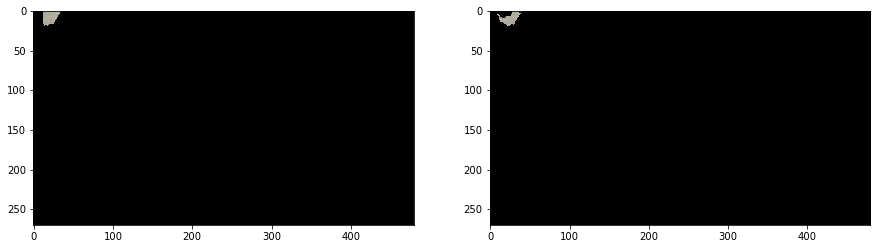

In [77]:
import math
from sklearn.mixture import GaussianMixture

spm = sp.SuperpixelsMaps([sp_map1, sp_map2])
msid1 = 1
sid1 = spm.msid2sid(0, msid1)
msid2 = 1
sid2 = spm.msid2sid(1, msid2)

himg1 = sp.highlight_superpixel(sp_map1, msid1)
img1_sp = img1.copy()
img1_sp[np.where(himg1 == 0)] = 0
himg2 = sp.highlight_superpixel(sp_map2, msid2)
img2_sp = img2.copy()
img2_sp[np.where(himg2 == 0)] = 0

def scale_colors(features, ch1=(0,255), ch2=(0,255), ch3=(0,255)):
    features = features.astype(np.float32)
    features[:,0] = (features[:,0] - ch1[0]) / (ch1[1]-ch1[0])
    features[:,1] = (features[:,1] - ch2[0]) / (ch2[1]-ch2[0])
    features[:,2] = (features[:,2] - ch3[0]) / (ch3[1]-ch3[0])
    return features

def compute_color_consistency(img1, sp_map1, msid1,
                              img2, sp_map2, msid2,
                              lambda_param=1.0,
                              n_components=15,
                              random_state=42):
    features1 = img1[sp_map1==msid1]
    features2 = img2[sp_map2==msid2]
    
    features1 = scale_colors(features1)
    features2 = scale_colors(features2)
    
    # Using two GMM objects
    gmm1 = GaussianMixture(n_components=n_components, random_state=random_state)
    gmm1.fit(features1)
    print(len(features1))
    print(features1[0])
    u1 = gmm1.means_
    
    # Sort the columns independently
    u1idx = u1.argsort(axis=0)
    u1 = u1[u1idx, np.arange(u1idx.shape[1])]
    print(u1)
    
    gmm2 = GaussianMixture(n_components=n_components, random_state=random_state)
    gmm2.fit(features2)
    u2 = gmm2.means_

    # Sort the columns independently
    u2idx = u2.argsort(axis=0)
    u2 = u2[u2idx, np.arange(u2idx.shape[1])]
    print(u2)
    
    # l2 norm squared
    # ||u||^2
    u = (u1 - u2)
    print(u)
#     u_norm_sq = math.sqrt(np.sum(u**2))
    u_norm_sq = np.sum(u**2)
    print(u_norm_sq)

    c = math.exp(-lambda_param * u_norm_sq)

    
    # Using one GMM object
#     gmm = GaussianMixture(n_components=n_components, random_state=random_state)
#     gmm.fit(features1)
#     c1 = gmm.score(features2)
    
#     print("c1:", c1)
    
#     gmm = GaussianMixture(n_components=n_components, random_state=random_state)
#     gmm.fit(features2)
#     c2 = gmm.score(features1)
#     print("c2:", c2)
    
#     c = c1 - c2
#     c = math.exp(c)

    # Using average color
#     u1 = np.mean(features1, axis=0)
#     u2 = np.mean(features2, axis=0)
#     print("u1:", u1)
#     print("u2:", u2)
#     u = (u1 - u2)
#     print("u:", u)
#     print("u**2:", u**2)
#     u_norm_sq = np.sum(u**2)
# #     u_norm_sq = math.sqrt(np.sum(u**2))
#     print("u_norm_sq:", u_norm_sq)
    
#     c = math.exp(-lambda_param * u_norm_sq)
    return c
    
print(compute_color_consistency(img1, sp_map1, msid1, img2, sp_map2, msid2,
                                n_components=15))

# Color consistency on similar color:
# print(compute_color_consistency(img1, sp_map1, msid1, img1, sp_map1, msid1,
#                                 n_components=15))

plt.figure(figsize=(15,15))
plt.subplot(221), plt.imshow(img1_sp)
plt.subplot(222), plt.imshow(img2_sp)
plt.show()

In [53]:
math.exp(-0.5)

0.6065306597126334

In [16]:
from numpy import linalg as LA
print(LA.norm([1, 2, 3])**2)
print(np.sum(np.array([1,2,3])**2))

14.0
14


In [6]:
ref_arr = np.array([[12, 22, 12, 13],
       [28, 26, 21, 23],
       [24, 14, 16, 25]])

sidx = ref_arr.argsort(axis=0)

print(sidx)

print(ref_arr[sidx, np.arange(sidx.shape[1])])

[[0 2 0 0]
 [2 0 2 1]
 [1 1 1 2]]
[[12 14 12 13]
 [24 22 16 23]
 [28 26 21 25]]
